In [39]:
# Import modules and subroutines:

include("../subroutines/Subroutines.jl");

In [2]:
# Load the chemical data into julia as an array of chemical data structs:
# (one struct obtained for each molecular geometry as set up in the config file)

cdata_list = ReadIn("../datasets/pyscf_data/h2o_sto-3g_080222%000756.hdf5");
chemical_data = cdata_list[1]
PrintChemData(chemical_data)

Molecule name: h2o
Basis set: sto-3g
Molecular geometry: O 0.0 0.0 0.0; H 1.0 0.0 0.0; H 0.0 1.0 0.0; 
RHF energy: -74.96117113786774
FCI energy: -75.01927599660624


In [3]:
# Run a DMRG calculation (i.e. a single-state subspace):

dmrg1 = GenSubspace(chemical_data, 1, psi_maxdim=7, sweep_num=10, sweep_noise=(1e-6, 1e-7, 1e-8, 0.0));

dmrg1.ord_list = [collect(1:dmrg1.chem_data.N_spt)]

GenStates!(dmrg1, verbose=true);

GenSubspaceMats!(dmrg1, verbose=true)

println("DMRG energy: ", dmrg1.H_mat[1,1] + dmrg1.chem_data.e_nuc)

dens = expect(dmrg1.psi_list[1],"Ntot")
println("Expected particle number: ", dmrg1.chem_data.N_el)
println("Particle number: ", sum(dens))


Generating states:
Progress: [1/1] 
Done!
computing matrix elements:
Progress: [1/1] 
Done!
DMRG energy: -75.01525960414277
Expected particle number: 10
Particle number: 10.000000000000005


In [4]:
Ipq = MutualInformation(dmrg1.psi_list[1], dmrg1.chem_data, dim=4);

display(Ipq)

7×7 Matrix{Float64}:
 0.0         1.01111e-5   2.1258e-6   1.82132e-6  …  1.28957e-6  4.49468e-6
 1.01111e-5  0.0          0.0082509   0.00993842     0.0110514   0.00877738
 2.1258e-6   0.0082509    0.0         0.0312925      0.0449167   0.073135
 1.82132e-6  0.00993842   0.0312925   0.0            0.0477318   0.0311182
 8.19579e-7  0.000265279  0.00069446  0.00106619     0.0047783   0.000494168
 1.28957e-6  0.0110514    0.0449167   0.0477318   …  0.0         0.044667
 4.49468e-6  0.00877738   0.073135    0.0311182      0.044667    0.0

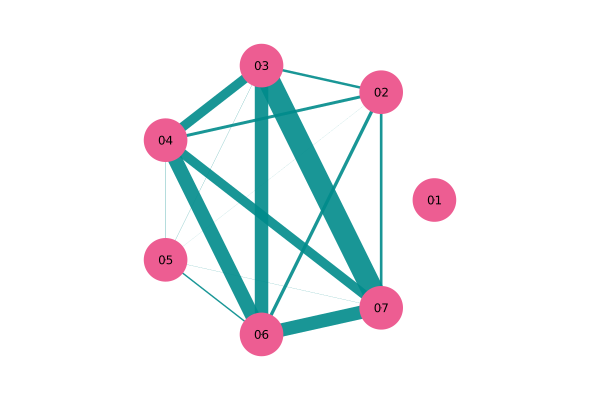

In [5]:
OrbitalGraphPlot(Ipq, multiplier=300)

[1, 5, 4, 6, 3, 7, 2]


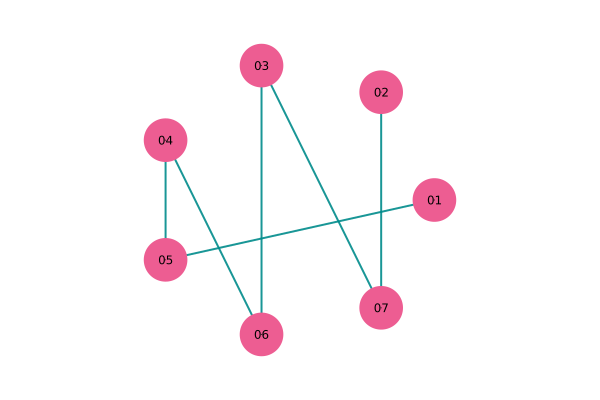

In [6]:
dmrg1.ord_list[1] = SimulatedAnnealing(Ipq, steps=1e4, tpow=5, swap_mult=3.0)

println(dmrg1.ord_list[1])

OrbitalGraphPlot(GraphMat(dmrg1.ord_list[1], directed=false), multiplier=2)

In [7]:
GenStates!(dmrg1, verbose=true);

GenSubspaceMats!(dmrg1, verbose=true)

println("DMRG energy: ", dmrg1.H_mat[1,1] + dmrg1.chem_data.e_nuc)

Generating states:
Progress: [1/1] 
Done!
computing matrix elements:
Progress: [1/1] 
Done!
DMRG energy: -75.00770959996548


In [34]:
# Set up a TNQE calculation (i.e. a multi-state non-orthogonal subspace):

tnqe1 = GenSubspace(chemical_data, 13, psi_maxdim=3, sweep_num=4, sweep_noise=1e-2);

ScreenOrderings!(tnqe1, maxiter=50, M_new=4, verbose=true);

computing matrix elements:
Progress: [91/91] 
Done!
Screening states (batch size = 4)
Progress: [50/50]; min. eval = -83.85936234230923 
Done!


computing matrix elements:
Progress: [91/91] 
Done!
Minimum eigenvalue: -83.85936234119475
Condition number: 253087.2597764439
FCI energy: -75.01927599660624
Final energy estimate: -75.01834217218384
Best single ref. estimate: -74.99665111606039
Error: 0.0009338244224039727
BSRfE: 0.022624880545848214
Improvement: 0.02169105612344424
Percentage error reduction: 95.87257744626928
Eigenvalue condition numbers: [0.2814, 4.9469, 5.0011, 10.7767, 28.4386, 5.5004, 17.8815, 12.1283, 7.4369, 78.5644, 39.4886, 107.879, 32.4017]
Percent correlation energy with single-geometry DMRG: 61.061981670637756
Percent correlation energy with multi-geometry TNQE: 98.39286344949811


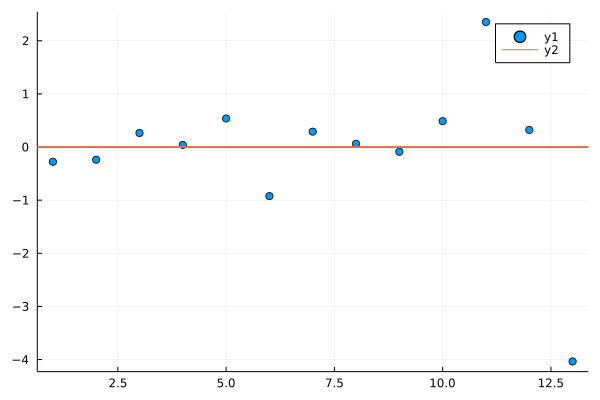

In [35]:
GenSubspaceMats!(tnqe1, verbose=true);

##### Solve the generalized eigenvalue problem:

#display(round.(tnqe1.H_mat,digits=3))
#display(round.(tnqe1.S_mat,digits=3))

SolveGenEig!(tnqe1, verbose=true)

In [42]:
BBOptimizeStates!(tnqe1,loops=1,sweeps=2,verbose=true);

Starting energy: -83.85989960232143

Starting run 1 of 1:
State: [13/13]; sweep: [2/2]; site: [6/6];  min. eval = -83.85992965152633 
Run 1 complete!
Ground state energy: -83.8599297594902
Condition number: 19414.460656608302


computing matrix elements:
Progress: [91/91] 
Done!
Minimum eigenvalue: -83.85992975949013
Condition number: 19414.460656602896
FCI energy: -75.01927599660624
Final energy estimate: -75.01890959047921
Best single ref. estimate: -74.99541914027905
Error: 0.00036640612702854014
BSRfE: 0.023856856327185483
Improvement: 0.023490450200156943
Percentage error reduction: 98.46414748865713
Eigenvalue condition numbers: [0.0589, 1.4245, 1.5257, 2.4608, 7.2739, 1.7302, 2.2704, 2.6234, 7.4859, 14.6359, 8.1045, 8.2787, 7.5305]
Percent correlation energy with single-geometry DMRG: 58.94171873895816
Percent correlation energy with multi-geometry TNQE: 99.36940535613806


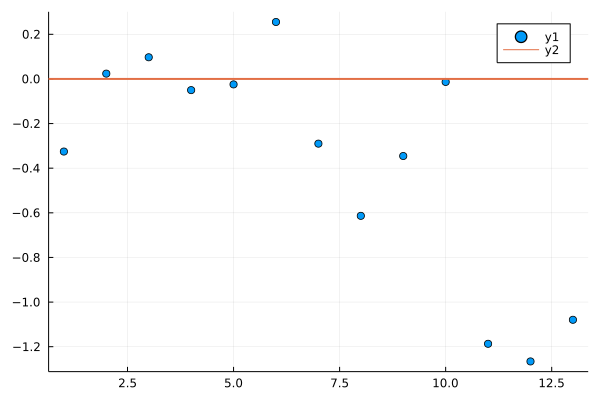

In [43]:
GenSubspaceMats!(tnqe1, verbose=true)

##### Solve the generalized eigenvalue problem:

SolveGenEig!(tnqe1, verbose=true)

Generating states:
Progress: [13/13] 
Done!
computing matrix elements:
Progress: [91/91] 
Done!
Minimum eigenvalue: -83.85323115724196
Condition number: 21506.15571283814
FCI energy: -75.01927599660624
Final energy estimate: -75.01221098823105
Best single ref. estimate: -74.99665111606032
Error: 0.0070650083751928605
BSRfE: 0.022624880545919268
Improvement: 0.015559872170726408
Percentage error reduction: 68.77327877663805
Eigenvalue condition numbers: [0.0437, 0.0184, 0.0556, 4.2744, 4.2041, 10.4517, 5.8083, 5.6818, 10.2611, 3.7786, 3.3024, 4.4148, 7.2909]
Percent correlation energy with single-geometry DMRG: 61.06198167051547
Percent correlation energy with multi-geometry TNQE: 87.84093356635029


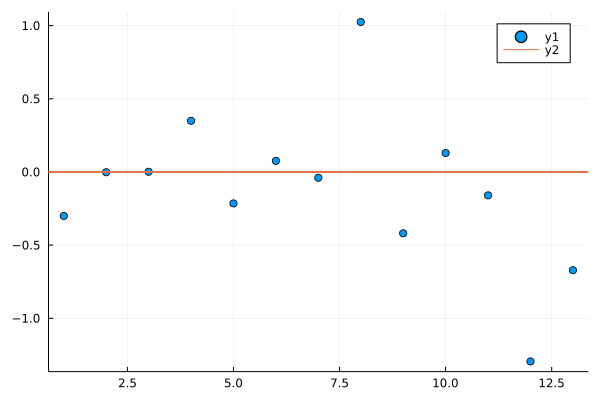

In [44]:
tnqe2 = copy(tnqe1)

GenStates!(tnqe2, verbose=true)

GenSubspaceMats!(tnqe2, verbose=true)

SolveGenEig!(tnqe2, verbose=true)

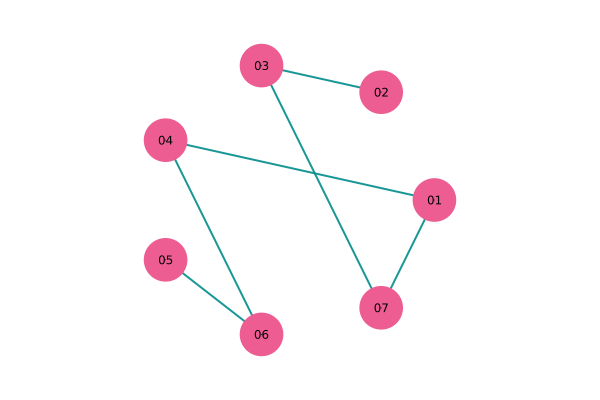

Weight: 0.3007423975545692


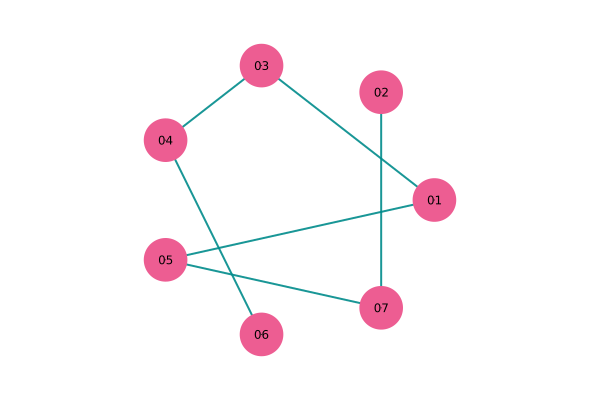

Weight: 0.002010418367922121


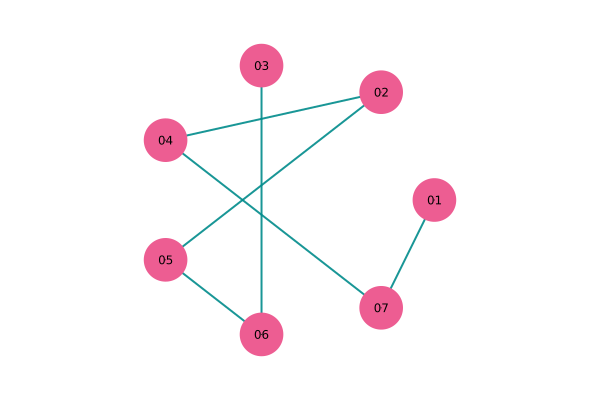

Weight: 0.0013820023993627113


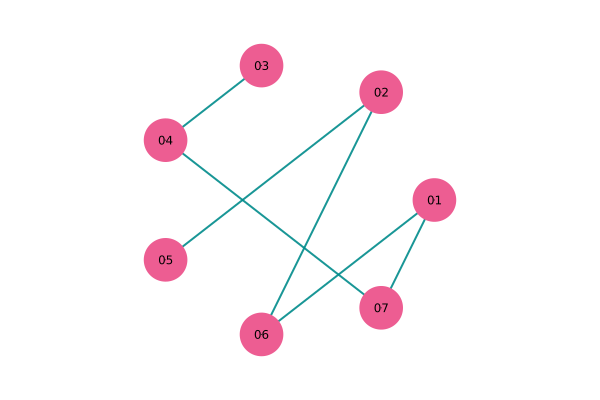

Weight: 0.34956562516239453


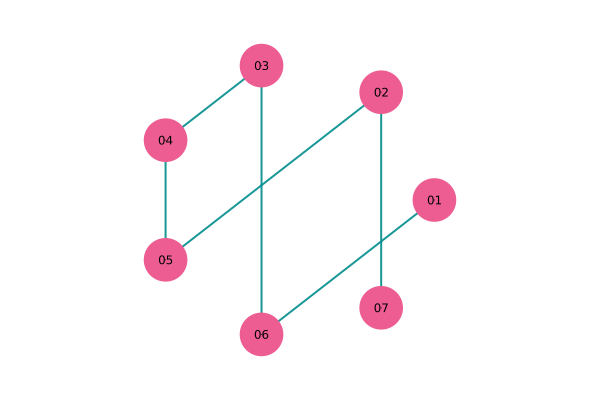

Weight: 0.2147561198926703


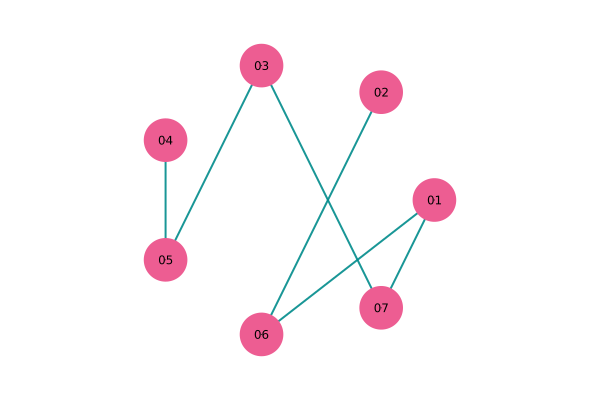

Weight: 0.07584090649733814


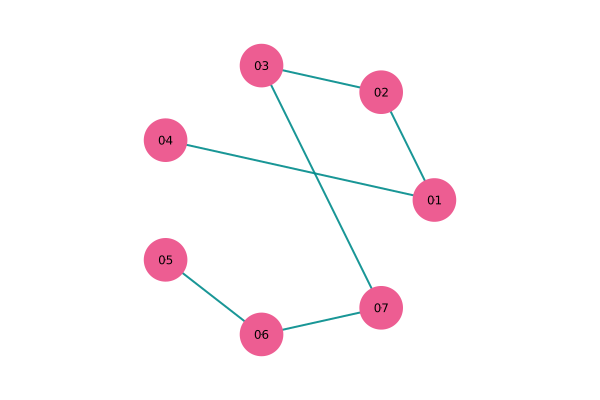

Weight: 0.03983139778686175


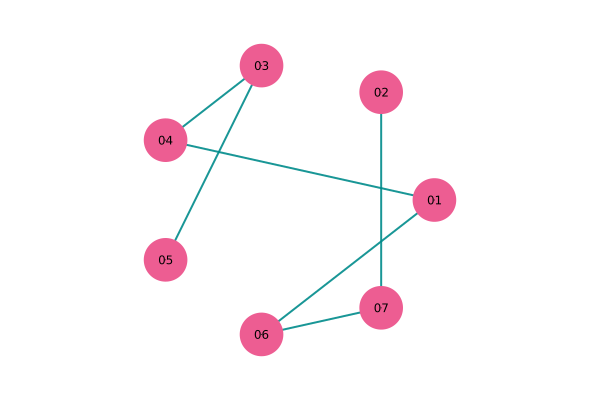

Weight: 1.0249231391271136


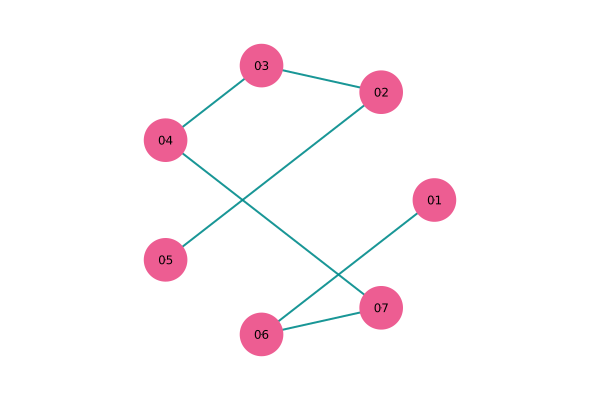

Weight: 0.41937690560397944


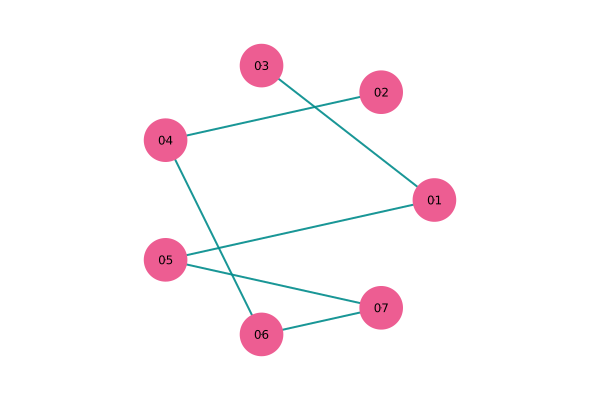

Weight: 0.12968666927927172


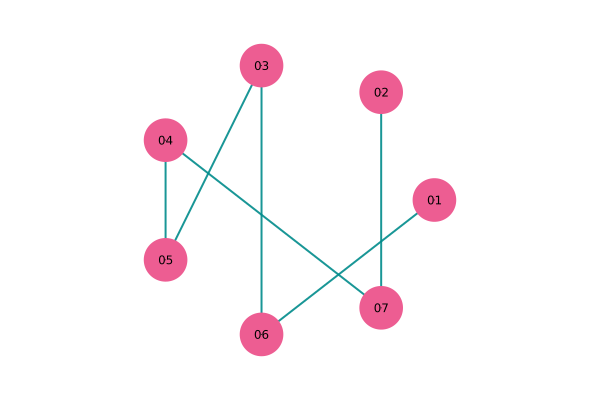

Weight: 0.15992758932761064


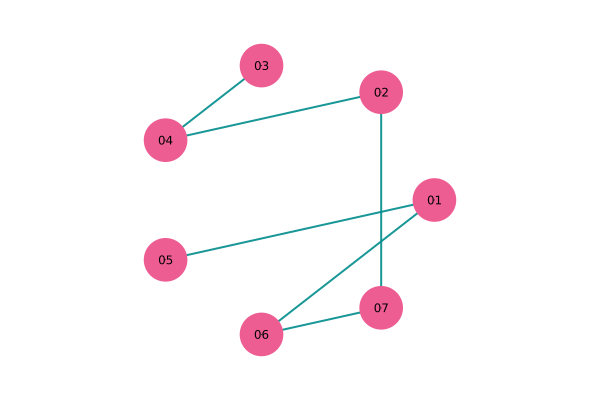

Weight: 1.2948995248735484


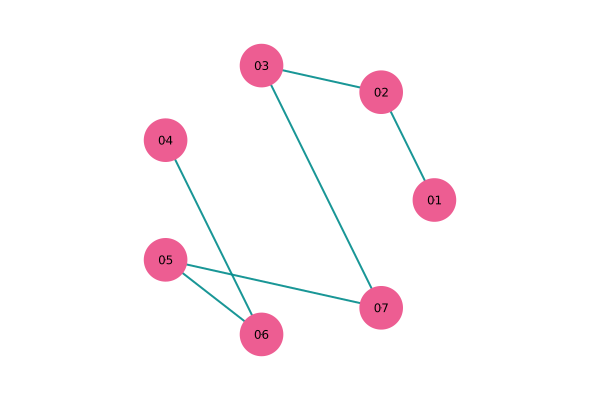

Weight: 0.6717412905072617


In [45]:

graph_mat_list = []

for (j,ord) in enumerate(tnqe2.ord_list)
    push!(graph_mat_list, GraphMat(ord, directed=false) )
end

for j=1:length(graph_mat_list)
    OrbitalGraphPlot(graph_mat_list[j], multiplier=2.0)
    println("Weight: ", abs(tnqe2.C[j,1]))
end